<a href="https://colab.research.google.com/github/tariqshaban/arabic-sign-language-image-classification/blob/master/Arabic%20Sign%20Language%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
# Display generic output messages
!pip install colorama

# Properly display Arabic characters in plots
!pip install arabic_reshaper
!pip install python-bidi

# Download assets from the GitHub repository
!apt install subversion
!svn checkout https://github.com/tariqshaban/arabic-sign-language-image-classification/trunk/assets

import arabic_reshaper
import cv2 as cv
import os
import re
import random
import shutil
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from bidi.algorithm import get_display
from colorama import Fore, Back, Style
from enum import Enum
from keras import activations
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras.utils import plot_model
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from glob import glob
from IPython.display import Image, display, clear_output

# Helps to finalize the seed
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.random.set_seed(1)

plt.rcParams["figure.figsize"] = (15, 8)

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



# Enumerations

### Enumerating Neural Network Types

In [2]:
class NeuralNetworkType(Enum):
    FULLY_CONNECTED_NETWORK = 'FullyConnectedNetwork_INEFFECTIVE_SCRATCH'
    CONVOLUTIONAL_NEURAL_NETWORK = 'ConvolutionalNeuralNetwork_SCRATCH'
    CONVOLUTIONAL_NEURAL_NETWORK_WITH_TRANSFER_LEARNING = 'ConvolutionalNeuralNetworkWithTransferLearning'

### Enumerating Neural Network Sizes

In [3]:
class NeuralNetworkSize(Enum):
    NANO = 'Nano_INEFFECTIVE'
    MICRO = 'Micro'
    SMALL = 'Small'

### Enumerating Hidden Layer Activation Function Types

In [4]:
class HiddenLayerActivationFunctionType(Enum):
    SIGMOID = 'Sigmoid_VANISHING'
    TANH = 'Tanh_VANISHING'
    RELU = 'ReLU'
    LEAKY_RELU = 'LeakyReLU'

### Enumerating Optimizers

In [5]:
class OptimizerType(Enum):
    SGD = 'SGD'
    RMS_PROP = 'RMSProp'
    ADAM = 'Adam'

# Global Variables

In [6]:
CLASSES_DF = pd.read_excel('./assets/Labels/ClassLabels.xlsx', index_col='ClassId')
CLASSES_DF.sort_values('ClassAr', inplace=True)

CLASSES = CLASSES_DF['Class'].to_list()
CLASSES_AR = CLASSES_DF['ClassAr'].to_list()

IMAGE_SHAPE = (64, 64, 3)

TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.2
TEST_SPLIT = 0.1

SOURCE_DIRECTORY = './assets/ArASL_Database_54K/'
REFACTORED_DIRECTORY = './assets/refactored_data/'
TRAIN_DIRECTORY = f'{REFACTORED_DIRECTORY}train/'
VALID_DIRECTORY = f'{REFACTORED_DIRECTORY}valid/'
TEST_DIRECTORY = f'{REFACTORED_DIRECTORY}test/'

BASE_MODEL = EfficientNetB0(weights='imagenet', include_top=False)
BASE_MODEL.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


# Helper Methods

### Get Neural Network

In [7]:
def get_neural_network():
    if NEURAL_NETWORK_SIZE == NeuralNetworkSize.NANO:
        scalar = 2
    elif NEURAL_NETWORK_SIZE == NeuralNetworkSize.MICRO:
        scalar = 4
    elif NEURAL_NETWORK_SIZE == NeuralNetworkSize.SMALL:
        scalar = 6

    def _get_fully_connected_network_block(x):
        return layers.Dense(pow(2, scalar - x + 5), activation=get_hidden_layer_activation_function())

    def _get_convolutional_neural_network_block(x):
        return [
            layers.Conv2D(filters=pow(2, x + 4), kernel_size=3),
            layers.BatchNormalization(),
            layers.Activation(get_hidden_layer_activation_function()),
            layers.MaxPooling2D((2, 2))
        ]

    def _get_convolutional_neural_network_with_transfer_learning_block(x):
        return layers.Dense(pow(2, scalar - x + 4), activation=get_hidden_layer_activation_function())

    if NEURAL_NETWORK_TYPE == NeuralNetworkType.FULLY_CONNECTED_NETWORK:
        return \
            [layers.Flatten(input_shape=IMAGE_SHAPE)] + \
            [_get_fully_connected_network_block(x) for x in range(1, scalar)]
    elif NEURAL_NETWORK_TYPE == NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK:
        blocks = [_get_convolutional_neural_network_block(x) for x in range(1, math.ceil(scalar / 2 + 2))]
        return \
            [layer for block in blocks for layer in block] + \
            [
                layers.GlobalAveragePooling2D(),
                layers.Dense(64, activation=get_hidden_layer_activation_function()),
                layers.Dense(32, activation=get_hidden_layer_activation_function())
            ]
    elif NEURAL_NETWORK_TYPE == NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK_WITH_TRANSFER_LEARNING:
        return \
            [
                BASE_MODEL,
                layers.GlobalAveragePooling2D(),
                layers.Dropout(0.5),
            ] + \
            [_get_convolutional_neural_network_with_transfer_learning_block(x) for x in range(1, scalar)]

### Get Hidden Layer Activation Function

In [8]:
def get_hidden_layer_activation_function():
    if HIDDEN_LAYER_ACTIVATION_FUNCTION_TYPE == HiddenLayerActivationFunctionType.SIGMOID:
        return activations.sigmoid
    elif HIDDEN_LAYER_ACTIVATION_FUNCTION_TYPE == HiddenLayerActivationFunctionType.TANH:
        return activations.tanh
    elif HIDDEN_LAYER_ACTIVATION_FUNCTION_TYPE == HiddenLayerActivationFunctionType.RELU:
        return activations.relu
    elif HIDDEN_LAYER_ACTIVATION_FUNCTION_TYPE == HiddenLayerActivationFunctionType.LEAKY_RELU:
        return activations.leaky_relu

### Get Optimizer

In [9]:
def get_optimizer():
    if OPTIMIZER_TYPE == OptimizerType.SGD:
        return tf.keras.optimizers.SGD()
    elif OPTIMIZER_TYPE == OptimizerType.RMS_PROP:
        return tf.keras.optimizers.RMSprop()
    elif OPTIMIZER_TYPE == OptimizerType.ADAM:
        return tf.keras.optimizers.Adam()

### Finalize Seed

In [10]:
def finalize_seed():
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

### Prime Dataset

In [11]:
def prime_dataset():
    if os.path.exists(REFACTORED_DIRECTORY):
        return

    # Create Training, Validation, and Testing directories
    for label in CLASSES:
        os.makedirs(f'{TRAIN_DIRECTORY}{label}', exist_ok=True)
        os.makedirs(f'{VALID_DIRECTORY}{label}', exist_ok=True)
        os.makedirs(f'{TEST_DIRECTORY}{label}', exist_ok=True)

    # Partition Images into Training, Validation, and Testing
    for label in CLASSES:
        numOfFiles = len(next(os.walk(f'{SOURCE_DIRECTORY}{label}/'))[2])

        for image_file in random.sample(glob(f'{SOURCE_DIRECTORY}{label}/*'), int(numOfFiles * TRAIN_SPLIT)):
            shutil.move(image_file, f'{TRAIN_DIRECTORY}{label}')

        for image_file in random.sample(glob(f'{SOURCE_DIRECTORY}{label}/*'), int(numOfFiles * VALID_SPLIT)):
            shutil.move(image_file, f'{VALID_DIRECTORY}{label}')

        for image_file in glob(f'{SOURCE_DIRECTORY}{label}/*'):
            shutil.move(image_file, f'{TEST_DIRECTORY}{label}')

### Explore Dataset

In [12]:
def explore_dataset(
        show_dataframe: bool = True,
        show_image_sample: bool = True,
        show_class_distribution: bool = True,
):
    if show_dataframe:
        print(CLASSES_DF)

    if show_image_sample:
        images = {}
        for label in next(os.walk(TRAIN_DIRECTORY))[1]:
            images[label] = cv.imread(f'{TRAIN_DIRECTORY}{label}/' + os.listdir(f'{TRAIN_DIRECTORY}{label}')[0])

        images = dict([(label, images[label]) for label in CLASSES])

        labels = [f'{ar} ({en})' for ar, en in zip(CLASSES_AR, CLASSES)]
        labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

        fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 12))
        for idx, label in enumerate(images):
            row = idx // 6
            col = idx % 6
            axes[row, col].axis('off')
            axes[row, col].imshow(images[label], cmap='gray', aspect='auto')
            axes[row, col].set_title(labels[idx])
        for axes in axes.flat[len(images):]:
            axes.remove()
        plt.show()

    if show_class_distribution:
        file_count = {
            'train': {},
            'valid': {},
            'test': {},
        }
        for root, subdirs, files in os.walk(REFACTORED_DIRECTORY):
            if not files:
                continue

            path = root.split('/')
            container = path[-2]
            letter = path[-1]

            file_count.setdefault(container, {})[letter] = len(files)

        file_count['train'] = dict([(get_display(arabic_reshaper.reshape(f'{row["ClassAr"]} ({row["Class"]})')), file_count['test'][row['Class']]) for _, row in CLASSES_DF.iterrows()])
        file_count['valid'] = dict([(get_display(arabic_reshaper.reshape(f'{row["ClassAr"]} ({row["Class"]})')), file_count['test'][row['Class']]) for _, row in CLASSES_DF.iterrows()])
        file_count['test'] = dict([(get_display(arabic_reshaper.reshape(f'{row["ClassAr"]} ({row["Class"]})')), file_count['test'][row['Class']]) for _, row in CLASSES_DF.iterrows()])

        plt.rcParams['figure.figsize'] = (15, 8)
        pd.DataFrame(file_count).plot(kind='bar', stacked=True, rot=45)
        plt.show()

### Build Model

In [13]:
def build_model(plot_network: bool = True, measure_performance: bool = True):
    if NEURAL_NETWORK_TYPE == NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK_WITH_TRANSFER_LEARNING:
        rescale = None
        target_size = (256, 256)
    else:
        rescale = 1 / 255
        target_size = IMAGE_SHAPE[:-1]

    train_batches = ImageDataGenerator(rescale=rescale).flow_from_directory(
        target_size=target_size,
        directory=TRAIN_DIRECTORY,
        classes=CLASSES,
        batch_size=128,
    )
    valid_batches = ImageDataGenerator(rescale=rescale).flow_from_directory(
        target_size=target_size,
        directory=VALID_DIRECTORY,
        classes=CLASSES,
        batch_size=128,
        shuffle=False,
    )
    test_batches = ImageDataGenerator(rescale=rescale).flow_from_directory(
        target_size=target_size,
        directory=TEST_DIRECTORY,
        classes=CLASSES,
        batch_size=128,
        shuffle=False,
    )

    model = Sequential(
        get_neural_network() +
        [layers.Dense(len(CLASSES), activation='softmax')]
    )

    model.compile(optimizer=get_optimizer(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=EARLY_STOPPING_PATIENCE)

    fitted_model = model.fit(x=train_batches, validation_data=valid_batches, epochs=EPOCHS, callbacks=[es])
    loss, accuracy = model.evaluate(x=test_batches, batch_size=128)

    print(Fore.GREEN + u'\n\u2713 ' + f'Loss ==> {loss}')
    print(Fore.GREEN + u'\n\u2713 ' + f'Accuracy ==> {accuracy}')

    if plot_network:
        plot_model(model, show_shapes=True, show_layer_activations=True)
        display(Image('model.png'))
        plt.show()
        model.summary()

    if measure_performance:
        plt.plot(fitted_model.history['accuracy'])
        plt.plot(fitted_model.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        plt.show()

        plt.plot(fitted_model.history['loss'])
        plt.plot(fitted_model.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        plt.show()

        y_pred = model.predict(test_batches)

        labels = [f'{ar} ({en})' for ar, en in zip(CLASSES_AR, CLASSES)]
        labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

        ax = sns.heatmap(confusion_matrix(test_batches.classes, y_pred.argmax(axis=1)), annot=True, cmap='Blues',
                         fmt='g')
        ax.set_title('Confusion Matrix')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Actual Values')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()

    return fitted_model

# Capturing input

In [14]:
# @title Seed Value { run: "auto", display-mode: "form" }

SEED = 42 # @param {type:"integer"}

print(Fore.GREEN + u'\u2713 ' + 'Attributes have been recorded successfully.\n')    
print(Style.RESET_ALL)

✓ Attributes have been recorded successfully.




In [15]:
# @title Neural Network Schematics { run: "auto", display-mode: "form" }

NEURAL_NETWORK_TYPE = NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK_WITH_TRANSFER_LEARNING  # @param ['NeuralNetworkType.FULLY_CONNECTED_NETWORK', 'NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK', 'NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK_WITH_TRANSFER_LEARNING'] {type:'raw'}
NEURAL_NETWORK_SIZE = NeuralNetworkSize.SMALL  # @param ['NeuralNetworkSize.NANO', 'NeuralNetworkSize.MICRO', 'NeuralNetworkSize.SMALL'] {type:'raw'}

print(Fore.GREEN + u'\u2713 ' + 'Attributes have been recorded successfully.\n')    
print(Style.RESET_ALL)

if 'INEFFECTIVE' in NEURAL_NETWORK_TYPE.value:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'An ineffective neural network model has been selected, this architecture may not be suitable for image tasks.')

if 'SCRATCH' in NEURAL_NETWORK_TYPE.value:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'A from-scratch neural network type has been selected, expect longer time runtimes to generalize.')
    
if 'INEFFECTIVE' in NEURAL_NETWORK_SIZE.value and NEURAL_NETWORK_TYPE != NeuralNetworkType.CONVOLUTIONAL_NEURAL_NETWORK_WITH_TRANSFER_LEARNING:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'A small neural network size has been selected, expect poor results.')

✓ Attributes have been recorded successfully.




In [16]:
# @title Hyperparameters { run: "auto", display-mode: "form" }

HIDDEN_LAYER_ACTIVATION_FUNCTION_TYPE = HiddenLayerActivationFunctionType.RELU  # @param ['HiddenLayerActivationFunctionType.SIGMOID', 'HiddenLayerActivationFunctionType.TANH', 'HiddenLayerActivationFunctionType.RELU', 'HiddenLayerActivationFunctionType.LEAKY_RELU'] {type:'raw'}
OPTIMIZER_TYPE = OptimizerType.ADAM  # @param ['OptimizerType.SGD', 'OptimizerType.RMS_PROP', 'OptimizerType.ADAM'] {type:'raw'}
EPOCHS = 30  # @param {type:"slider", min:1, max:100, step:1}
EARLY_STOPPING_PATIENCE = 10  # @param {type:"integer"}

print(Fore.GREEN + u'\u2713 ' + 'Attributes have been recorded successfully.\n')
print(Style.RESET_ALL)

if 'VANISHING' in HIDDEN_LAYER_ACTIVATION_FUNCTION_TYPE.value:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'An activation function with a vanishing gradient problem has been selected, the model may not generalize well.')

if EPOCHS < 10:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'The selected number of epochs is low, the model may not generalize well.')

if EARLY_STOPPING_PATIENCE > 10:
    print(Back.YELLOW + Fore.BLACK + u'\u26A0 ' +
          'Patience value is high, expect longer runtimes.')

print(Style.RESET_ALL)

✓ Attributes have been recorded successfully.





# Methods Invocation

In [17]:
finalize_seed()

In [18]:
prime_dataset()

         Class ClassAr
ClassId               
29          ya       ئ
1           al      ال
2        aleff     الف
3           bb     باء
27        toot       ة
24         taa     تاء
25        thaa     ثاء
12        jeem     جيم
11         haa     حاء
14        khaa     خاء
4          dal     دال
26        thal     ذال
19          ra     راء
31         zay     زاي
21        seen     سين
22       sheen     شين
20        saad     صاد
6         dhad     ضاد
23          ta     طاء
5          dha     ظاء
0          ain     عين
9        ghain     غين
7           fa     فاء
8         gaaf     قاف
13        kaaf     كاف
15          la      لا
16        laam     لام
17        meem     ميم
18         nun     نون
10          ha     هاء
28         waw     واو
30         yaa     ياء


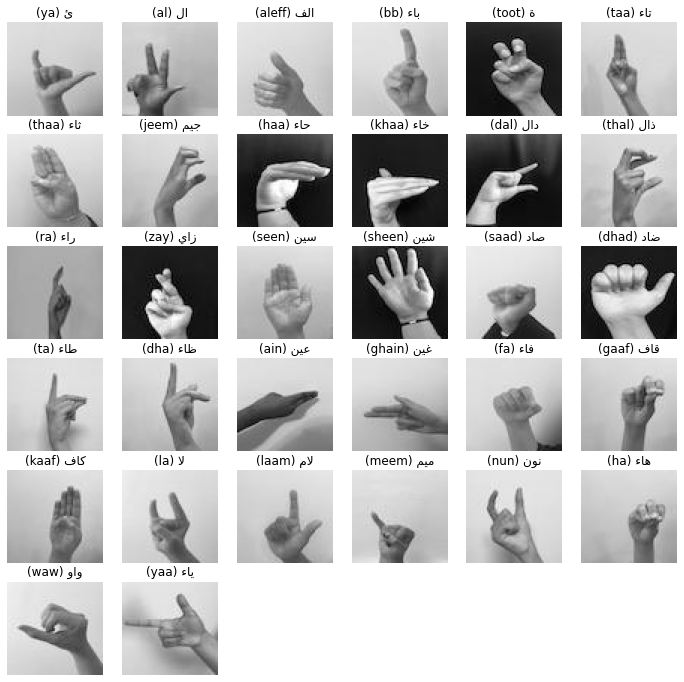

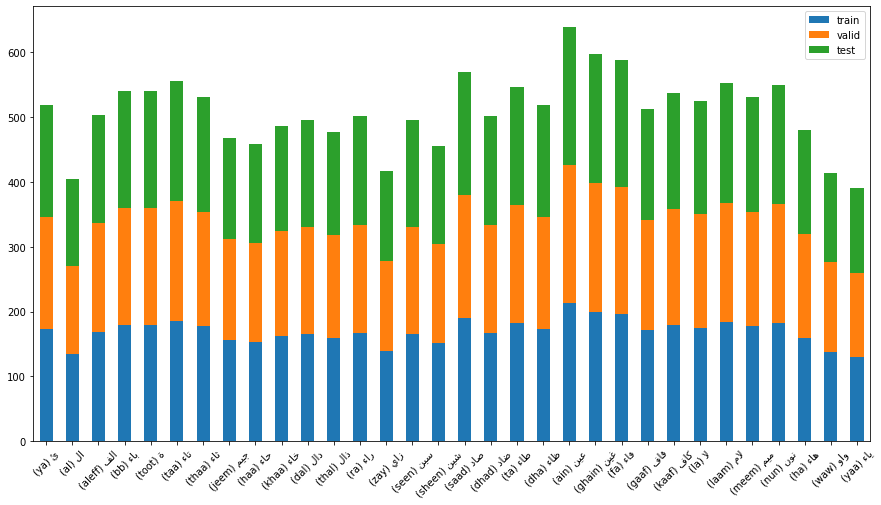

In [19]:
explore_dataset()

Found 37819 images belonging to 32 classes.
Found 10797 images belonging to 32 classes.
Found 5433 images belonging to 32 classes.
Epoch 1/30
296/296 [==============================] - 179s 533ms/step - loss: 1.5031 - accuracy: 0.5285 - val_loss: 0.5692 - val_accuracy: 0.8272
Epoch 2/30
296/296 [==============================] - 153s 516ms/step - loss: 0.7576 - accuracy: 0.7485 - val_loss: 0.3511 - val_accuracy: 0.8962
Epoch 3/30
296/296 [==============================] - 154s 522ms/step - loss: 0.5941 - accuracy: 0.8021 - val_loss: 0.2643 - val_accuracy: 0.9216
Epoch 4/30
296/296 [==============================] - 154s 520ms/step - loss: 0.5024 - accuracy: 0.8350 - val_loss: 0.2221 - val_accuracy: 0.9332
Epoch 5/30
296/296 [==============================] - 154s 521ms/step - loss: 0.4422 - accuracy: 0.8566 - val_loss: 0.2100 - val_accuracy: 0.9303
Epoch 6/30
296/296 [==============================] - 154s 521ms/step - loss: 0.3978 - accuracy: 0.8718 - val_loss: 0.1618 - val_accuracy: 

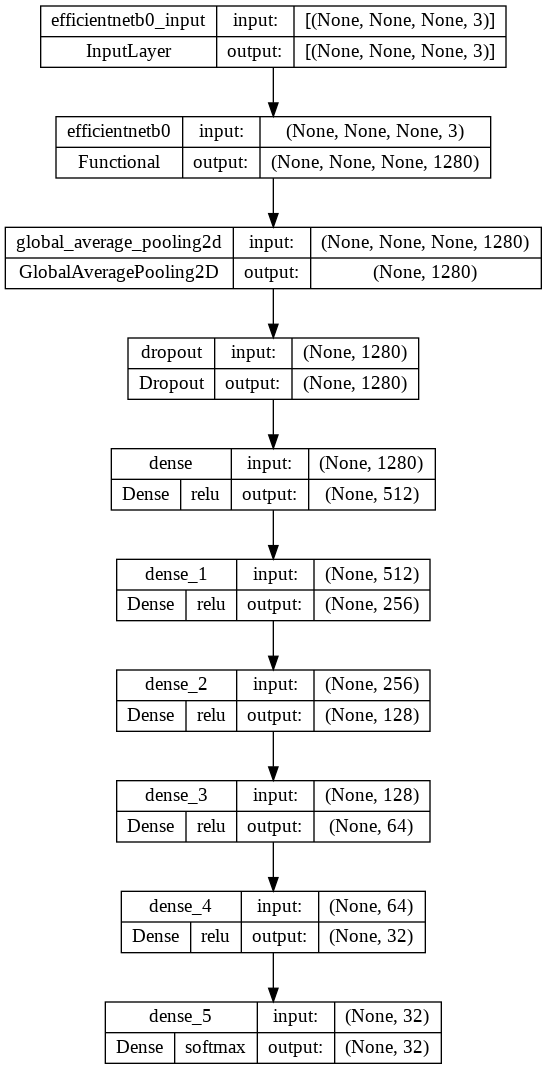

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

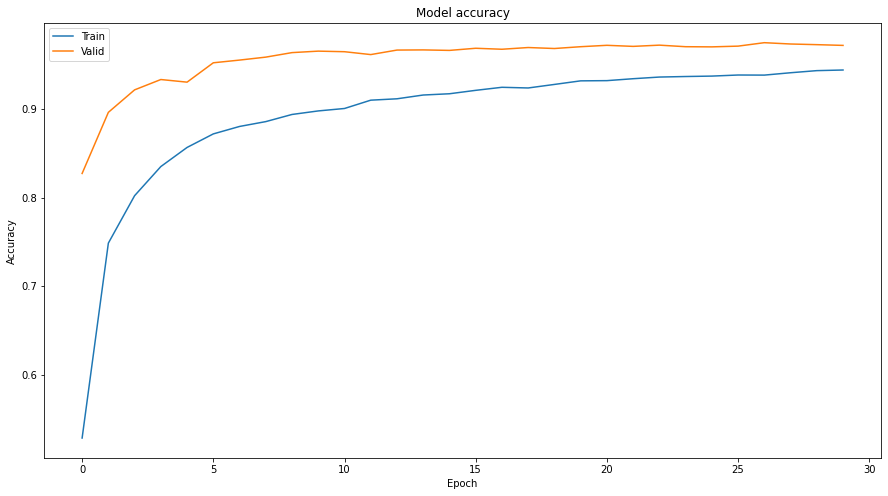

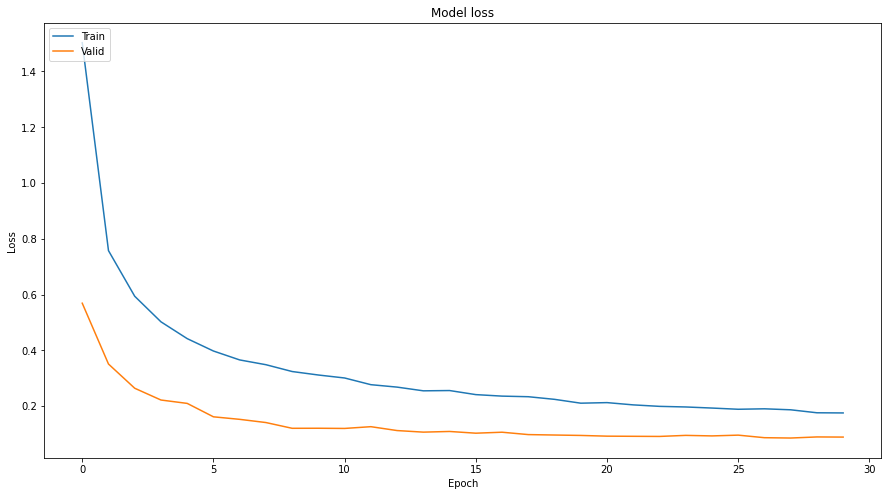

43/43 [==============================] - 18s 389ms/step


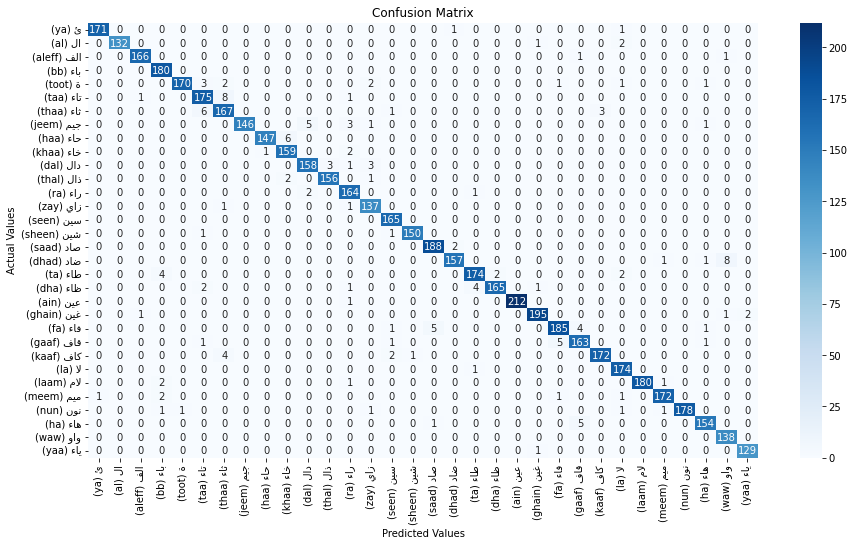

In [20]:
model = build_model()